# Цифровая обработка сигналов - 5

| **Title**         | Digital signal processing |
| --- | --- |
| **Author**        | Alexander Kapitanov       |
| **Contact**       | sallador@bk.ru            |
| **Project lang**  | Python                    |
| **Packages**      | numpy, scipy, matplotlib  |
| **License**       | GNU GPL 3.0               |


## Введение

Перед вами обучающий материал по основам **цифровой обработки сигналов** с использованием средств языка программирования Python. Предполагается, что читатель имеет базовые знания из области высшей математики, а также владеет языком Python и хотя бы поверхностно знает различные python-библиотеки - numpy/scipy, matplotlib и другие. 

Для пользователей MATLAB / GNU Octave освоение материала с точки зрения программного кода не составит труда, поскольку основные функции и их атрибуты во многом идентичны и схожи с методами из python-библиотек.

## Сигналы

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, rfft, fftshift

%matplotlib inline

## Детерминированные сигналы

В мире существует множество сигналов различной формы, однако в задачах цифровой и аналоговой обработки часто используются известные сигналы - гармонической формы, модулированные (по амплитуде, частоте или фазе). Как известно, сигнал любой формы можно представить как совокупность гармонических сигналов разных частот и амплитуд (то есть набор спектральных отсчетов). Можно сказать, что чем сложнее сигнал - тем больше спектральных отсчетов требуется для его представления. В частности, для представления сигналов с резкими изменениями формы требуются высокие частоты спектра, а для "гладких" сигналов и медленно меняющихся процессов высокие частоты не требуются и не вносят вклад в результирующий сигнал (и его спектр).

### Гармонический сигнал

Гармонический сигнал задается уравнением:  

$s(t) = A \cdot cos(2\pi ft +\phi)$, 

где *A* – амплитуда колебания, f - частота сигнала, φ – начальная фаза. 

Комплексная запись такого сигнала:

$s = A \cdot e^{j(2\pi ft +\phi)}$, 

где *j* - комплексная единица. Часто выражается как $j = \sqrt-1$

Ниже представлен график гармонического сигнала при различных параметрах значения частоты. Амплитуда = 1, начальная фаза = 0 (константы).

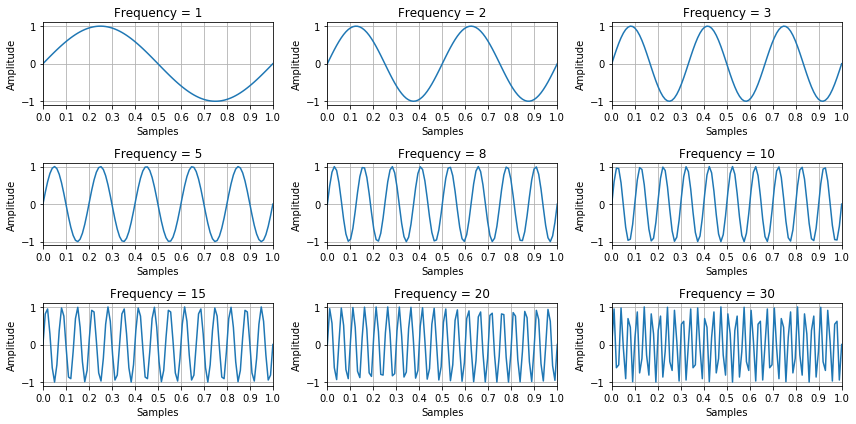

In [2]:
n = 100
t = np.linspace(0, 1, n, endpoint=True)

# list of frequencies
f_list = np.array([1, 2, 3, 5, 8, 10, 15, 20, 30])

plt.figure(figsize=(12, 6))
for i, freq in enumerate(f_list):
    plt.subplot(3, 3, i+1)
    plt.plot(t, np.sin(2*np.pi*freq*t))
    plt.title(f'Frequency = {freq}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.xlim([0, 1])
    plt.xticks(np.linspace(0, 1, 11, endpoint=True))
    plt.grid()
plt.tight_layout()

### Амплитудная модуляция

Амплитудная модуляция - широко известный способ изменения формы сигнала по параметру амплитуды. Из названия очевидно, что амплитуда такого сигнала изменяется во времени. Закон изменения амплитуды - произвольный, на практике часто используется модуляция гармоническим колебанием.

Формула простейшего гармонического АМ-сигнала:  

$s(t) = A_c \cdot (1 + m \cdot cos(\omega_mt +\phi)) \cdot cos(\omega_сt)$, 

где 
- $A_{c}$ – амплитуда несущего колебания, 
- $\omega_{c}$ – частота несущего сигнала, 
- $\omega_{m}$ – частота модулирующего (информационного) сигнала, 
- $\phi$ – начальная фаза модулирующего сигнала,
- *m* - коэффициент модуляции.

Тогда, радиосигнал состоит из несущего колебания и двух боковых полос. Из названия, очевидно, что несущая частота - та, на которой распространяется сигнал. Как правило, это высокая частота относительно модулирующей частоты.

Модулирующая частота, в свою очередь, низкочастотная. Это такая частота, на которой передается информационное сообщение.

Для синусоидального сигнала, использованного в качестве примера боковые полосы представляют собой синусоидальные сигналы и их частоты равны $\omega_{c}+\omega_{m}$ и $\omega_{c}-\omega_{m}$. Спектр АМ-сигнала всегда симметричен относительно центральной (несущей) частоты.

Важно понимать, что центральная частота не несет полезной информации, хоть и называется "несущая". В это понятие вкладывается значение частоты, относительно которого располагаются информационные (модулирующие) частоты сигнала. 

Создадим функцию АМ-сигнала:

In [3]:
def signal_am(amp=1.0, km=0.25, fc=10.0, fs=2.0, period=100):
    """
    Create Amplitude modulation (AM) signal

    Parameters
    ----------
    amp : float
        Signal magnitude
    km : float
        Modulation coeff: amplitude sensitivity 0 <= km < 1
    fc : float
        Carrier frequency
    fs : float
        Signal frequency
    period : integer
        Number of points for signal (same as period)
    """
    tt = 2.0 * np.pi * np.linspace(0, 1, period)
    return amp * (1 + km * np.cos(fs * tt)) * np.cos(fc * tt)

На приведенных ниже графиках показано, как меняется форма и спектр АМ-сигнала при изменении параметра **несущей частоты** $f_c$:

Как видно, спектр АМ-сигнала состоит из трех компонент: центральная - несущая, и две боковые - модулирующие. При изменении несущей частоты происходит смещение всего АМ-сигнала по частоте.

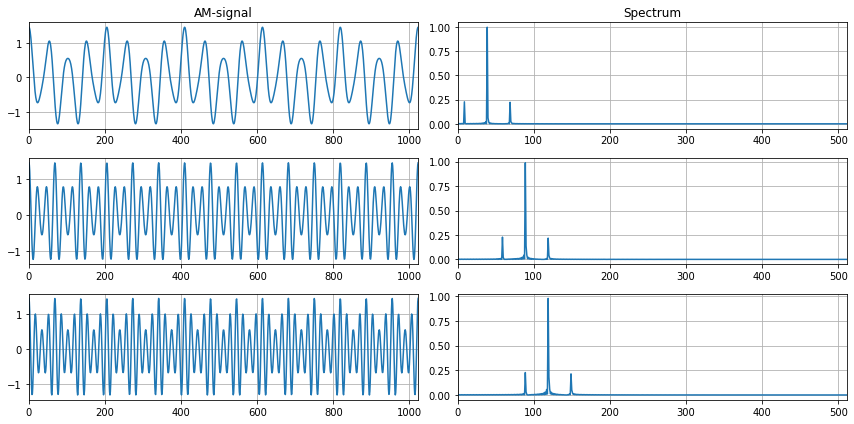

In [4]:
N = 1024

# Create AM-signal
fs = 15             # Modulation frequency
fc = [20, 45, 60]   # Carrier frequency

sig = [signal_am(amp=1.0, km=0.45, fc=i, fs=fs, period=N) for i in fc]

# Calculate FFT
sft = np.abs(rfft(sig, axis=1)) / N / 0.5

plt.figure(figsize=(12, 6))
for i, freq in enumerate(fc):
    plt.subplot(len(fc), 2, 2*i+1)
    if i == 0:
        plt.title('AM-signal')
    plt.plot(sig[i])
    plt.xlim([0, N-1])
    plt.grid(True)
    
    plt.subplot(len(fc), 2, 2*i+2)
    if i == 0:
        plt.title('Spectrum')
    plt.plot(sft[i])
    plt.xlim([0, N//2-1])
    plt.grid(True)
plt.tight_layout()

На приведенных ниже графиках показано, как меняется форма и спектр АМ-сигнала при изменении параметра **частоты модулирующего колебания** $f_s$:

Как видно, при изменении модулирующей частоты, спектр не сдвигается, но изменяется расстрояние между центральной (несущей) частотой и боковыми (модулирующими) частотами. 

Ширина спектра АМ сигнала равна удвоенной частоте модулирующего сигнала.

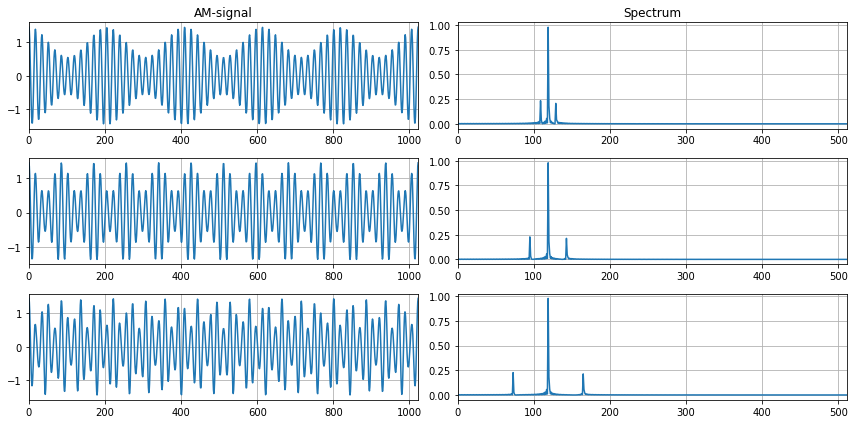

In [5]:
N = 1024
# Create AM-signal
fs = [5, 12, 23]    # Modulation frequency
fс = 60             # Carrier frequency

sig = [signal_am(amp=1.0, km=0.45, fc=fс, fs=i, period=N) for i in fs]

# Calculate FFT
sft = np.abs(rfft(sig, axis=1)) / N / 0.5

plt.figure(figsize=(12, 6))
for i, freq in enumerate(fs):
    plt.subplot(len(fc), 2, 2*i+1)
    if i == 0:
        plt.title('AM-signal')
    plt.plot(sig[i])
    plt.xlim([0, N-1])
    plt.grid(True)
    
    plt.subplot(len(fs), 2, 2*i+2)
    if i == 0:
        plt.title('Spectrum')
    plt.plot(sft[i])
    plt.xlim([0, N//2-1])
    plt.grid(True)
plt.tight_layout()

Наконец, посмотрим, как меняется форма и спектр АМ-сигнала при изменении параметра **коэффициента модуляции** $k_m$:

Как видно, при изменении коэффициента модуляции, спектр сигнала остается на месте. Меняется только уровень боковых составляющих. Заметим, что при $k_m > 1$ возникает так называемая избыточная модуляция (перемодуляция). Максимальное значение коэффициента модуляции, при котором не возникает перемодуляции АМ-сигнала $k_m = 1$. 

Амплитуда центральной гармоники равна амплитуде несущего колебания: $A_c = A_o$. 

Амплитуда боковых составляющих равна $A_m = \frac{A_o\cdot m}{2}$



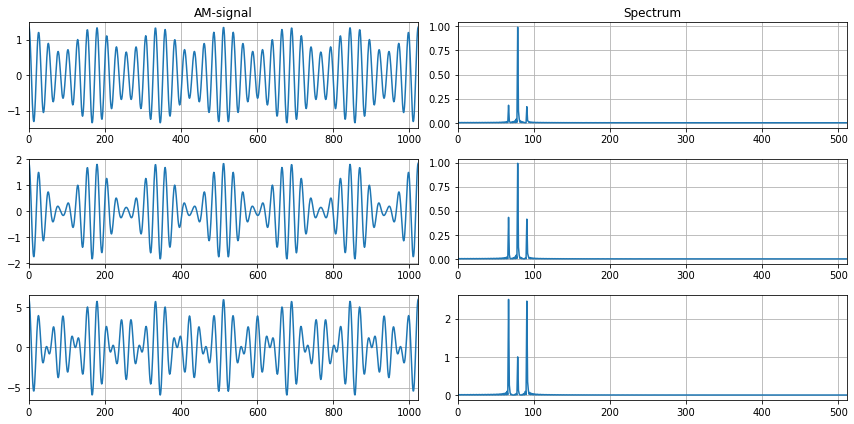

In [6]:
N = 1024
# Create AM-signal
fs = 6                  # Modulation frequency
fс = 40                 # Carrier frequency
km = [0.35, 0.85, 5]    # modulation coeff.

sig = [signal_am(amp=1.0, km=i, fc=fс, fs=fs, period=N) for i in km]

# Calculate FFT
sft = np.abs(rfft(sig, axis=1)) / N / 0.5

plt.figure(figsize=(12, 6))
for i, freq in enumerate(km):
    plt.subplot(len(km), 2, 2*i+1)
    if i == 0:
        plt.title('AM-signal')
    plt.plot(sig[i])
    plt.xlim([0, N-1])
    plt.grid(True)
    
    plt.subplot(len(km), 2, 2*i+2)
    if i == 0:
        plt.title('Spectrum')
    plt.plot(sft[i])
    plt.xlim([0, N//2-1])
    plt.grid(True)
plt.tight_layout()

Среди класса сигналов с амплитудной модуляцией есть ряд сигналов, которые лучше используют энергетические характеристики сигнала. Например, сигналы с подавленой несущей относятся к классу АМ-сигналов, и позволяют производить передачу сообщений более экономно в плане энергетических спектральных характеристиик.
____

### Угловая модуляция

Под термином угловая модуляция понимается модуляция по фазе или по частоте (математически можно представить, что изменяется "угол" тригонометрической функции). Таким образом, сигналы с угловой модуляцией делятся на **частотно-модулированные** (ЧМ) сигналы и **фазо-модулированные** (ФМ) сигналы.

При фазовой модуляции значение угла фазы изменяется пропорционально информационному сообщению, при частотной модуляции информационный сигнал управляет частотой несущего колебания. В обоих случаях амплитуда сигнала остается неизменной.

Сигналы с угловой модуляцией применяются в музыкальных синтезаторах, в телевещании для передачи звука и сигнала цветности, а также для качественной передачи звуковых сообщений (например, радиовещание в УКВ диапазоне). Высокое качество в сравнении с АМ-сигналами достигается за счет лучшего использования частотного диапазона передаваемого сообщения. Иными словами, в полосе сигнала укладывается больше информации, чем в сигналах с АМ-модуляцией. Кроме того, информационное сообщение сигналов с угловой модуляцией менее подвержено серьёзному влиянию окружающей среды при передаче, поскольку информация содержится не в амплитуде. Очевидно, что в процессе распространения сигнал чаще претерпевает изменения амплитуды, чем изменения фазы или частоты.

Формула сигнала с угловой модуляцией:  

$s(t) = A \cdot cos(2\pi f_c t + k u_{m}(t)) $ 

В случае модуляции гармоническим колебанием: 

$s(t) =  A_c \cdot cos(2\pi f_c t + \frac{A_{m} f_{\Delta}}{f_{m}} sin(2\pi f_s t)) $, 

где 
- $A_{c}$ – амплитуда несущего колебания, 
- $A_{m}$ – амплитуда модулирующего колебания, 
- $f_{c}$ – частота несущего сигнала, 
- $f_{m}$ – частота модулирующего (информационного) сигнала, 
- $f_{\Delta}$ – девиация частоты.

Отношение девиации частоты к частоте модулирующего колебания называют индексом частотной модуляции. Как и в случае с АМ-колебанием, модулирующая частота - низкочастотная относительно частоты несущей. 

Создадим упрощенную python-функцию ЧМ-сигнала:

- $A_{mp}$ – амплитуда колебания, 
- $f_{c}$ – частота несущего сигнала, 
- $f_{m}$ – частота модулирующего сигнала, 
- $k_{d}$ – девиация частоты.

In [7]:
def signal_fm(amp=1.0, kd=0.25, fc=10.0, fs=2.0, period=100):
    """
    Create Frequency modulation (FM) signal

    Parameters
    ----------
    amp : float
        Signal magnitude
    kd : float
        Frequency deviation, kd < period/4,
        e.g. fc = 0, fs = 1, kd = 16
    fc : float
        Carrier frequency
    fs : float
        Signal frequency
    period : integer
        Number of points for signal (same as period)
    """
    tt = 2.0 * np.pi * np.linspace(0, 1, period)
    return amp * np.cos(fc * tt + kd/fs * np.sin(fs * tt))

Построим сигналы с частотной модуляцией в зависимости от значения девиации частоты:

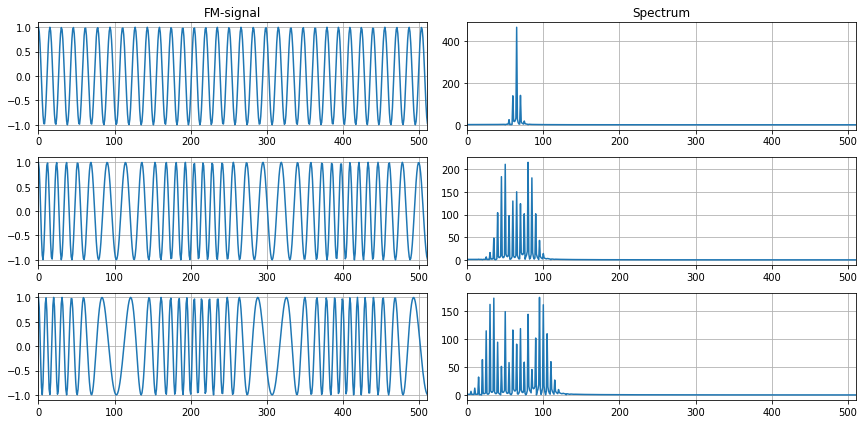

In [8]:
N = 1024
fs = 5            # Modulation frequency
fс = 65           # Carrier frequency
kd = [3, 23, 40]  # modulation coeff.

sig = [signal_fm(amp=1.0, kd=i, fc=fс, fs=fs, period=N) for i in kd]

# Calculate FFT
sft = np.abs(fft(sig, axis=1))

plt.figure(figsize=(12, 6))
for i, freq in enumerate(kd):
    plt.subplot(len(kd), 2, 2*i+1)
    if i == 0:
        plt.title('FM-signal')
    plt.plot(sig[i])
    plt.xlim([0, N//2-1])
    plt.grid(True)
    
    plt.subplot(len(kd), 2, 2*i+2)
    if i == 0:
        plt.title('Spectrum')
    plt.plot(sft[i])
    plt.xlim([0, N//2-1])
    plt.grid(True)
plt.tight_layout()

Как видно, чем больше девиация по частоте, тем шире спектр сигнала с угловой модуляцией.
____

### Линейная частотная модуляция

Сигналы с линейной частотной модуляцией (ЛЧМ) сигналы - это класс сигналов с частотной модуляцией, при которой частота несущего сигнала изменяется по линейному закону. 

В задачах радиолокации часто требуется получить заданную разрешающую способность по дальности, определямую как минимальное расстояние между двумя целями, при которой дальность до каждой из целей определяется раздельно. Эта величина обратно пропорциональна ширине спектра сигнала. Следовательно необходимо увеличивать ширину спектра для уменьшения значения разрешающей способности.

Увеличение ширины спектра сигнала можно достичь с помощью уменьшения длительности сигнала. Но это в свою очередь приводит к уменьшению энергии сигнала и дальности обнаружения. Компромиссное решение - использование сигналов сложной формы, в частности - ЛЧМ-сигналов.

Функция изменения частоты линейна: 

$ f(t) = f_{0} + k t $ 

где:

- $ f_{0} = (F_{max} + F_{min}) / 2 $ - центральное значение несущей частоты.
- $ k = (F_{max}-F_{min}) / T_{c} $ - коэффициент модуляции
- $ T_c $ - длительность сигнала

Основное применение ЛЧМ-сигналов - задачи радиолокации. Широкополосные ЛЧМ сигналы позволяют обеспечить высокую разрешающую способность по дальности без уменьшения длительности посылаемых (зондируемых) импульсов.

Основное понятие ЛЧМ сигнала - это база сигнала, которая характеризуется произведением ширины спектра и длительности импульса сигнала. 

$ \beta = \Delta f \cdot \tau $

Если база ЛЧМ сигнала $ \beta >> 1 $, то его спектр стремится к прямоугольному виду, а фазовый спектр имеет квадратичную зависимость от частоты. Известно, что при прохождении через согласованный фильтр происходит сжатие ЛЧМ-сигнала. Это в свою очередь порождает узкий корреляционный пик большой амплитуды.  

Для сжатия ЛЧМ сигналов часто применяется операция быстрой свёртки, которая строится на базовых функциональных блоках цифровой обработки. Это ядра быстрого преобразования Фурье (БПФ), комплексные перемножители и блоки памяти, содержащие набор коэффициентов опорной функции.  

Как видно, базовые операции цифровой обработки применимы и к задачам радиолокации. 

ЛЧМ сигнал опишем формулой:

$ s(t) = A cos(2\pi f_{0}t + \pi\beta t^{2}) $ 

где

- $ A $ - амплитуда сигнала.
- $ f_{0} $ - начальное значение частоты,
- $ \beta $ - коэффициент ЛЧМ-модуляции,

Соответствующая функция на python:

In [9]:
def signal_chirp(amp=1.0, freq=0.0, beta=0.25, period=100, **kwargs):
    """
    Create Chirp signal

    Parameters
    ----------
    amp : float
        Signal magnitude
    beta : float
        Modulation bandwidth: beta < N for complex, beta < 0.5N for real
    freq : float or int
        Linear frequency of signal
    period : integer
        Number of points for signal (same as period)
    kwargs : bool
        Complex signal if is_complex = True
        Modulated by half-sine wave if is_modsine = True
    """
    is_complex = kwargs.get('is_complex', False)
    is_modsine = kwargs.get('is_modsine', False)

    t = np.linspace(0, 1, period)
    tt = np.pi * (freq * t + beta * t ** 2)
    
    if is_complex is True:
        res = amp * (np.cos(tt) + 1j * np.sin(tt))
    else:
        res = amp * np.cos(tt)

    if is_modsine is True:
        return res * np.sin(np.pi * t)
    return res

Построим график ЛЧМ-сигнала для разных значений параметра $\beta$. Как видно, при увеличении параметра, расширяется спектр сигнала. 

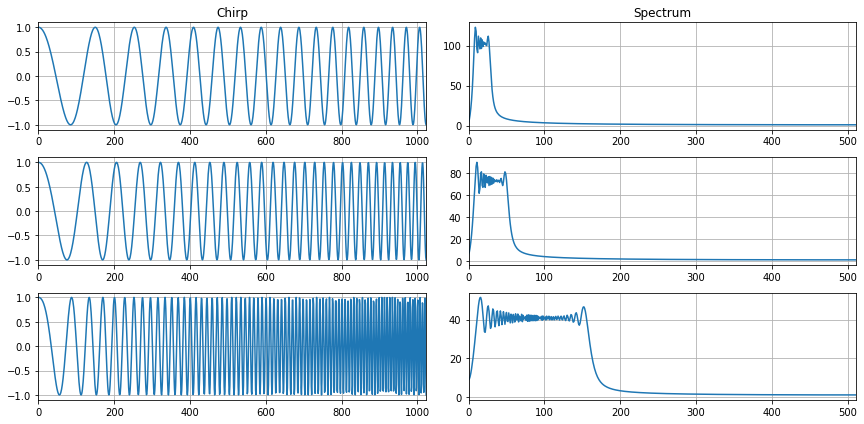

In [10]:
N = 1024
beta = [25, 49, 157]

schirp = [signal_chirp(amp=1, freq=10, beta=i, period=N) for i in beta]

# Calculate FFT
sft = np.abs(fft(schirp, axis=1))

plt.figure(figsize=(12, 6))
for i, freq in enumerate(kd):
    plt.subplot(len(kd), 2, 2*i+1)
    if i == 0:
        plt.title('Chirp')
    plt.plot(schirp[i])
    plt.xlim([0, N-1])
    plt.grid(True)
    
    plt.subplot(len(kd), 2, 2*i+2)
    if i == 0:
        plt.title('Spectrum')
    plt.plot(sft[i])
    plt.xlim([0, N//2-1])
    plt.grid(True)
plt.tight_layout()

#### Комплексный ЛЧМ-сигнал

Зачастую ЛЧМ-импульсы дополнительно модулируются синусоидальной огибающей для достижения лучших спектральных характеристик. Также можно использовать комплексный ЛЧМ-сигнал.

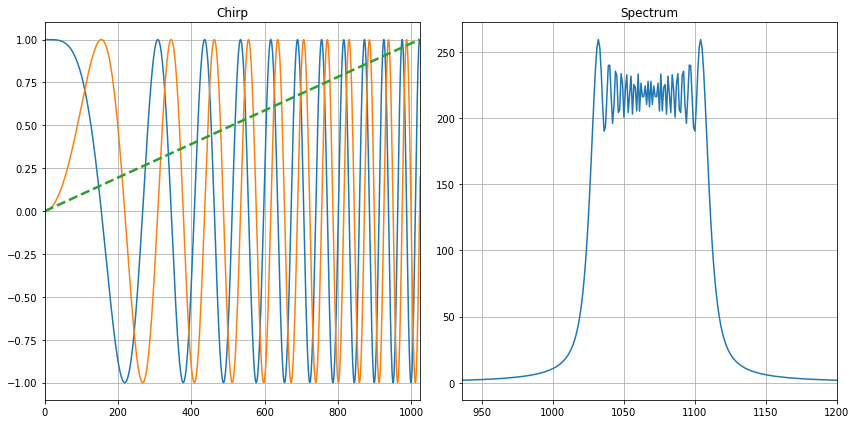

In [11]:
N = 2048
beta = 88

schirp = signal_chirp(amp=1, freq=0, beta=beta, period=N, is_complex=True)

# Calculate FFT
sft = np.abs(fftshift(fft(schirp)))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Chirp')
plt.plot(np.real(schirp))
plt.plot(np.imag(schirp))
plt.plot(np.linspace(0, 1, N//2), '--', linewidth='2.5')
plt.xlim([0, N//2])
plt.grid(True)
    
plt.subplot(1, 2, 2)
plt.title('Spectrum')
plt.plot(sft)
plt.xlim([N//2-beta, N//2+2*beta])
plt.grid(True)
plt.tight_layout()